# Data understanding

De gebruikte dataset is “Vestigingen_Gemeente" (https://opendata.cbs.nl/statline/#/CBS/nl/dataset/81575NED/table?ts=1584707583585). 

De CBS data is een csv bestand, dit staat voor comma seperated values of door comma gescheide waarden in het nederlands.
De data bevat de volgende kolomen:
 - `ID` is de unieke waarde voor elke row.
 - `Bedrijfstakken/branches SBI 2008` geeft de waarde weer in welke bedrijfstak/branch de bedrijfen zit.
 - `Perioden` geeft de periode aan waarin de bedrijfstak/branch actief in is.
 - `Regio's` is de regio waarin de behorende bedrijfstak/branch actief in is.
 - `Vestigingen (aantal)` is de aantal vestigingen die binnen die bedrijfstak/branch geteld zijn per regio en per periode.

## Beschrijven van de data

Hieronder staat een beschrijving van de data vanuit de Centraal Bureau Statistieken. Dit wordt telkens door middel van een stukje code weergegeven. 

In [190]:
import pandas as pd
import geopandas as gpd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from prep import movecol
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, _plot_corr
from statsmodels.tsa.arima_model import ARIMA

pd.set_option('display.max_rows', 50)

# Dataset inlezen
file = "../raw-data/Vestegingen_Gemeente.csv"
postcode_file = "../raw-data/gemeenten-provincie.xlsx"
data_pc = pd.read_excel(postcode_file)
data_vg = pd.read_csv(file, sep=";")

# Dataverkennen door dataframe te openen
data_vg

,Bedrijfstakken/branches SBI 2008,Perioden,Regio's,Vestigingen (aantal)
0,"A Landbouw, bosbouw en visserij",2013,Amsterdam,95
1,"A Landbouw, bosbouw en visserij",2014,Amsterdam,100
2,"A Landbouw, bosbouw en visserij",2015,Amsterdam,105
3,"A Landbouw, bosbouw en visserij",2016,Amsterdam,105
4,"A Landbouw, bosbouw en visserij",2017,Amsterdam,110
...,...,...,...,...
1933,U Extraterritoriale organisaties,2014,Zwolle,0
1934,U Extraterritoriale organisaties,2015,Zwolle,0
1935,U Extraterritoriale organisaties,2016,Zwolle,0
1936,U Extraterritoriale organisaties,2017,Zwolle,0


In [191]:
regios = data_vg["Regio's"].drop_duplicates()
regios

0                     Amsterdam
6                        Arnhem
12                        Assen
18                        Breda
24                    Eindhoven
30                     Enschede
36     's-Gravenhage (gemeente)
42         Groningen (gemeente)
48                      Haarlem
54             's-Hertogenbosch
60                   Leeuwarden
66                       Leiden
72                     Lelystad
78                   Maastricht
84              Middelburg (Z.)
90                    Rotterdam
96                      Tilburg
102          Utrecht (gemeente)
108                      Zwolle
Name: Regio's, dtype: object

In [192]:
data_pc

,Regio's,Provincie
0,Appingedam,Groningen
1,Bedum,Groningen
2,Bellingwedde,Groningen
3,Ten Boer,Groningen
4,Delfzijl,Groningen
...,...,...
454,Venlo,Limburg
455,Venray,Limburg
456,Voerendaal,Limburg
457,Weert,Limburg


In [193]:
# Info over de kolommen
groepeerde_data_vg = data_vg.groupby(["Regio's", "Perioden"]).sum()
info_kolommen_vg = data_vg.info()
info_kolommen_vg

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1938 entries, 0 to 1937
Data columns (total 4 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   Bedrijfstakken/branches SBI 2008  1938 non-null   object
 1   Perioden                          1938 non-null   int64 
 2   Regio's                           1938 non-null   object
 3   Vestigingen (aantal)              1938 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 60.7+ KB


In [194]:
# Beschrijvende statistieken van de data
beschrijvende_stats_vg = data_vg.describe()
beschrijvende_stats_vg

,Perioden,Vestigingen (aantal)
count,1938.000000,1938.000000
mean,2015.500000,1256.542828
std,1.708266,2690.824443
min,2013.000000,0.000000
25%,2014.000000,66.250000
50%,2015.500000,470.000000
75%,2017.000000,1248.750000
max,2018.000000,36290.000000


In [195]:
# Informatie over de kolomnamen in de Dataframe
data_vg.columns

Index(['Bedrijfstakken/branches SBI 2008', 'Perioden', 'Regio's',
       'Vestigingen (aantal)'],
      dtype='object')

In [196]:
# Controleren op nulwaarden in de dataframe
data_vg.isna().sum()

Bedrijfstakken/branches SBI 2008    0
Perioden                            0
Regio's                             0
Vestigingen (aantal)                0
dtype: int64

## Data exploratie

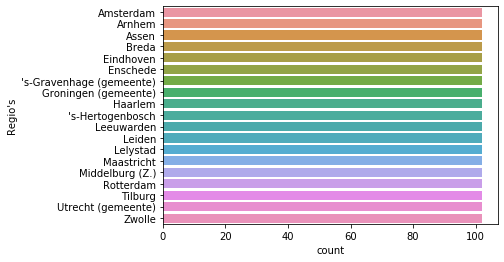

In [197]:
# Het laten zien van hoevaak een regio voorkomt in de dataset.
sb.countplot(y="Regio's", data=data_vg)

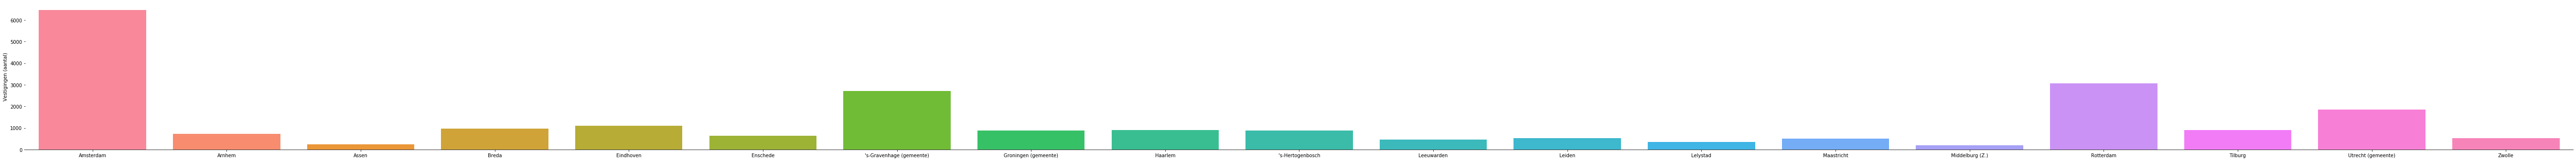

In [198]:
g = sb.catplot(x="Regio's", y="Vestigingen (aantal)",
                data=data_vg, saturation=10,
                kind="bar", ci=None, aspect=15)
(g.set_axis_labels("", "Vestigingen (aantal)")
  .set_titles("{col_name} {col_var}")
  .despine(left=True))

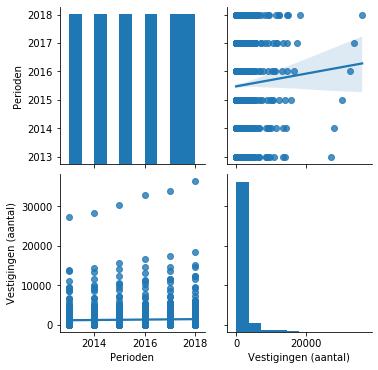

In [199]:
sb.pairplot(data_vg, kind="reg")

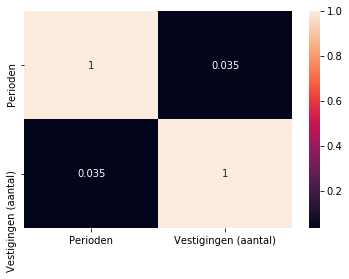

In [200]:
sb.heatmap(data_vg.corr(), annot=True)

### Samenvatting

Er zijn nu 2 datasets:
- `data_vg` is de 'standaard' dataframe met alle kolommen en waardes die compleet zijn.
- `groepeerde_data_vg` is de **gegroepeerde** dataset, gegroepeerd op de kolommen `Regio's` en `Perioden`.

# Data Preparation

Tijdens de analyse van de benodigde data worden de datasets `data_vg` en `groepeerde_data_vg` gebruikt. Van deze dataset wordt de data vanaf het jaar 2013 t/m 2018 gebruikt. De jaren 2019 en 2020 zijn wel beschikbaar, maar nog niet volledig.

Om te bepalen welke data gebruikt dient te worden, wordt er gekeken naar hoe de data aan de data mining goals kan voldoen. De data mining goal is: **Het verhogen van succesvolle woningzoekers die op zoek zijn naar een woonplek**.

De `data_vg` focust zich op het zoeken van mogelijke werkplekken van een woningzoekende in de ideale regio. De user story die beantwoordt dient te worden met de `data_vg` is **Als bezoeker wil ik graag dat werkgelegenheid mee wordt geteld in de resultaten, zodat ik kan de hoeveelheid mogelijke werkplekken per regio als resultaat zie**.

Ook wordt er een dataframe `data_pc` toegevoegd aan `data_vg`, zodat per regio de plaats, gemeente en provincie wordt weergegeven.

## Select Data

Van `data_vg_2018` worden alle kolommen gebruikt voor het beantwoorden van de user story.

Van `data_pc` wordt een aantal kolommen gebruikt, namelijk:
- `Plaats`.
- `Gemeente`.
- `Provincie`.



In [201]:
data_pc.columns

Index(['Regio's', 'Provincie'], dtype='object')

In [202]:
data_pc

,Regio's,Provincie
0,Appingedam,Groningen
1,Bedum,Groningen
2,Bellingwedde,Groningen
3,Ten Boer,Groningen
4,Delfzijl,Groningen
...,...,...
454,Venlo,Limburg
455,Venray,Limburg
456,Voerendaal,Limburg
457,Weert,Limburg


## Clean Data

In dit onderdeel wordt gekeken welke acties moeten worden ondernomen om de data op te schonen. Er wordt bijvoorbeeld gekeken naar rare waardes, aanpassingen in de records of overige acties.

In [203]:
# Unieke waarden in de verschillende kolommen van data_vg
test = ["Bedrijfstakken/branches SBI 2008", "Perioden", "Regio's", "Vestigingen (aantal)"]
for i in test:
    print(i, data_vg[i].unique())

Bedrijfstakken/branches SBI 2008 ['A Landbouw, bosbouw en visserij' 'B Delfstoffenwinning' 'C Industrie'
 'D Energievoorziening' 'E Waterbedrijven en afvalbeheer'
 'F Bouwnijverheid' 'G Handel' 'H Vervoer en opslag' 'I Horeca'
 'J Informatie en communicatie' 'K Financiële dienstverlening'
 'L Verhuur en handel van onroerend goed'
 'M Specialistische zakelijke diensten'
 'N Verhuur en overige zakelijke diensten' 'R Cultuur, sport en recreatie'
 'S Overige dienstverlening' 'U Extraterritoriale organisaties']
Perioden [2013 2014 2015 2016 2017 2018]
Regio's ['Amsterdam' 'Arnhem' 'Assen' 'Breda' 'Eindhoven' 'Enschede'
 "'s-Gravenhage (gemeente)" 'Groningen (gemeente)' 'Haarlem'
 "'s-Hertogenbosch" 'Leeuwarden' 'Leiden' 'Lelystad' 'Maastricht'
 'Middelburg (Z.)' 'Rotterdam' 'Tilburg' 'Utrecht (gemeente)' 'Zwolle']
Vestigingen (aantal) [   95   100   105   110   120    50    55    65    75    80   220   215
   225    40    45   150   145   155   175   185   190  1540  1480  1490
  1555  1640

Uit de vorige functie is te herlijden dat:
- `Bedrijfstakken/branches SBI 2008` heeft geen opmerkelijke waarden. Alle records zijn volgens hetzelfde format ingevuld.
- `Perioden` is gereed voor gebruik.
- `Regio's` heeft een aantal dubbele waarden, maar die worden weer gescheiden door de afkorting van de province van de Regio.
- `Vestigingen (aantal)` heeft een opmerkelijke notatie die op basis van vorige functie anders word weergegeven dan in de tabelweergave. De waarden zijn echter correct en hetzelfde, maar met een andere notatie. Het valt op dat er in deze kolom een NaN waarde zit, dat dient aangepast te worden.

In [204]:
# Controleren op de lege waardes
data_vg_incl_provincie.isna().sum()

Bedrijfstakken/branches SBI 2008    0
Perioden                            0
Regio's                             0
Provincie                           0
Vestigingen (aantal)                0
dtype: int64

In [205]:
# Invullen van de Na/NaN waarden in kolom Vestigingen (aantal) door 0
data_vg2 = data_vg["Vestigingen (aantal)"].fillna(0)
data_vg2

0        95
1       100
2       105
3       105
4       110
       ... 
1933      0
1934      0
1935      0
1936      0
1937      0
Name: Vestigingen (aantal), Length: 1938, dtype: int64

## Construct data

Om de data bruikbaar te maken voor user input in het formulier, wordt een classificatie aangebracht aan het aantal vestigingen. De waarde van deze classificatie zal bepaald worden door de uitkomst van data_vg.describe() uit de data understanding. De klassen zijn:
- `Laag`.
- `Middel`.
- `Hoog`.
- `Geen`.


In [206]:
data_vg_incl_provincie = pd.merge(data_vg, data_pc, left_on="Regio's", right_on="Regio's")
data_vg_incl_provincie

,Bedrijfstakken/branches SBI 2008,Perioden,Regio's,Vestigingen (aantal),Provincie
0,"A Landbouw, bosbouw en visserij",2013,Amsterdam,95,Noord-Holland
1,"A Landbouw, bosbouw en visserij",2014,Amsterdam,100,Noord-Holland
2,"A Landbouw, bosbouw en visserij",2015,Amsterdam,105,Noord-Holland
3,"A Landbouw, bosbouw en visserij",2016,Amsterdam,105,Noord-Holland
4,"A Landbouw, bosbouw en visserij",2017,Amsterdam,110,Noord-Holland
...,...,...,...,...,...
1933,U Extraterritoriale organisaties,2014,Zwolle,0,Overijssel
1934,U Extraterritoriale organisaties,2015,Zwolle,0,Overijssel
1935,U Extraterritoriale organisaties,2016,Zwolle,0,Overijssel
1936,U Extraterritoriale organisaties,2017,Zwolle,0,Overijssel


In [207]:
data_vg_incl_provincie = movecol(data_vg_incl_provincie, cols_to_move=['Provincie'], ref_col="Regio's", place='After')

data_vg_incl_provincie

,Bedrijfstakken/branches SBI 2008,Perioden,Regio's,Provincie,Vestigingen (aantal)
0,"A Landbouw, bosbouw en visserij",2013,Amsterdam,Noord-Holland,95
1,"A Landbouw, bosbouw en visserij",2014,Amsterdam,Noord-Holland,100
2,"A Landbouw, bosbouw en visserij",2015,Amsterdam,Noord-Holland,105
3,"A Landbouw, bosbouw en visserij",2016,Amsterdam,Noord-Holland,105
4,"A Landbouw, bosbouw en visserij",2017,Amsterdam,Noord-Holland,110
...,...,...,...,...,...
1933,U Extraterritoriale organisaties,2014,Zwolle,Overijssel,0
1934,U Extraterritoriale organisaties,2015,Zwolle,Overijssel,0
1935,U Extraterritoriale organisaties,2016,Zwolle,Overijssel,0
1936,U Extraterritoriale organisaties,2017,Zwolle,Overijssel,0


In [208]:
werkgelegenheid_groupby = data_vg_incl_provincie.groupby(['Provincie',"Regio's", 'Perioden', 'Bedrijfstakken/branches SBI 2008']).sum()

werkgelegenheid_groupby

Vestigingen (aantal)
Provincie    Regio's   Perioden Bedrijfstakken/branches SBI 2008                             
Drenthe      Assen     2013     A Landbouw, bosbouw en visserij                            65
                                B Delfstoffenwinning                                        5
                                C Industrie                                               160
                                D Energievoorziening                                        0
                                E Waterbedrijven en afvalbeheer                            10
...                                                                                       ...
Zuid-Holland Rotterdam 2018     M Specialistische zakelijke diensten                    14655
                                N Verhuur en overige zakelijke diensten                  2910
                                R Cultuur, sport en recreatie                            5440
                                S Overige dienstverlening                                3330
                                U Extraterritoriale organisaties                            0

[1938 rows x 1 columns]

In [209]:
np.set_printoptions(threshold=np.inf)

min_max_scaler = preprocessing.MinMaxScaler()

aantal_vestigingen_minmax = min_max_scaler.fit_transform(data_vg_incl_provincie[["Vestigingen (aantal)"]])
werkgelegenheid_groupby["Aantal_vestigingen_genormaliseerd"] = aantal_vestigingen_minmax

werkgelegenheid_groupby

Vestigingen (aantal)  \
Provincie    Regio's   Perioden Bedrijfstakken/branches SBI 2008                                
Drenthe      Assen     2013     A Landbouw, bosbouw en visserij                            65   
                                B Delfstoffenwinning                                        5   
                                C Industrie                                               160   
                                D Energievoorziening                                        0   
                                E Waterbedrijven en afvalbeheer                            10   
...                                                                                       ...   
Zuid-Holland Rotterdam 2018     M Specialistische zakelijke diensten                    14655   
                                N Verhuur en overige zakelijke diensten                  2910   
                                R Cultuur, sport en recreatie                            5440   
                                S Overige dienstverlening                                3330   
                                U Extraterritoriale organisaties                            0   

                                                                         Aantal_vestigingen_genormaliseerd  
Provincie    Regio's   Perioden Bedrijfstakken/branches SBI 2008                                            
Drenthe      Assen     2013     A Landbouw, bosbouw en visserij                                   0.002618  
                                B Delfstoffenwinning                                              0.002756  
                                C Industrie                                                       0.002893  
                                D Energievoorziening                                              0.002893  
                                E Waterbedrijven en afvalbeheer                                   0.003031  
...                                                                                                    ...  
Zuid-Holland Rotterdam 2018     M Specialistische zakelijke diensten                              0.000000  
                                N Verhuur en overige zakelijke diensten                           0.000000  
                                R Cultuur, sport en recreatie                                     0.000000  
                                S Overige dienstverlening                                         0.000000  
                                U Extraterritoriale organisaties                                  0.000000  

[1938 rows x 2 columns]

In [210]:
werkgelegenheid_groupby.describe()

,Vestigingen (aantal),Aantal_vestigingen_genormaliseerd
count,1938.000000,1938.000000
mean,1256.542828,0.034625
std,2690.824443,0.074148
min,0.000000,0.000000
25%,66.250000,0.001826
50%,470.000000,0.012951
75%,1248.750000,0.034410
max,36290.000000,1.000000


De data van werkgelegenheid_groupby wordt gecategoriseerd op een `Geen`, `Laag`, `Middel` of `Hoog` aantal vestigingen in een bepaalde branche.

In [211]:
#werkgelegenheid_groupby.drop(columns=["Klasse vestigingsaantal"])
vestigingen = werkgelegenheid_groupby["Aantal_vestigingen_genormaliseerd"]

# Gebruik de aantallen die bij vg_data.describe() staan
werk_25 = vestigingen.quantile(q=.25)
werk_50 = vestigingen.quantile(q=.5)
werk_75 = vestigingen.quantile(q=.75)

print(werk_25, werk_50, werk_75)

# Gebruik de aantallen die bij vg_data.describe() staan
m1 = np.logical_and(vestigingen < werk_25, vestigingen != 0)
m2 = np.logical_and(vestigingen >  werk_25, vestigingen < werk_50)
m3 = np.logical_and(vestigingen >  werk_50, vestigingen < werk_75)
m4 = vestigingen > werk_75

werkgelegenheid_groupby["Vestigingen Klasse"] = np.select([m1,m2,m3,m4], ['Laag','Middel','Middel-Hoog','Hoog'], default='Geen')

werkgelegenheid_groupby.tail(50)

0.001825571782860292 0.012951226233122072 0.0344103058693855


Vestigingen (aantal)  \
Provincie    Regio's   Perioden Bedrijfstakken/branches SBI 2008                                
Zuid-Holland Rotterdam 2016     B Delfstoffenwinning                                       15   
                                C Industrie                                              2215   
                                D Energievoorziening                                       50   
                                E Waterbedrijven en afvalbeheer                            90   
                                F Bouwnijverheid                                         4430   
                                G Handel                                                 9195   
                                H Vervoer en opslag                                      2435   
                                I Horeca                                                 2395   
                                J Informatie en communicatie                             3405   
                                K Financiële dienstverlening                             3725   
                                L Verhuur en handel van onroerend goed                    930   
                                M Specialistische zakelijke diensten                    13205   
                                N Verhuur en overige zakelijke diensten                  2640   
                                R Cultuur, sport en recreatie                            4850   
                                S Overige dienstverlening                                3025   
                                U Extraterritoriale organisaties                            0   
                       2017     A Landbouw, bosbouw en visserij                           330   
                                B Delfstoffenwinning                                       10   
                                C Industrie                                              2220   
                                D Energievoorziening                                       45   
                                E Waterbedrijven en afvalbeheer                            90   
                                F Bouwnijverheid                                         4710   
                                G Handel                                                 9235   
                                H Vervoer en opslag                                      2650   
                                I Horeca                                                 2455   
                                J Informatie en communicatie                             3535   
                                K Financiële dienstverlening                             3805   
                                L Verhuur en handel van onroerend goed                    955   
                                M Specialistische zakelijke diensten                    13635   
                                N Verhuur en overige zakelijke diensten                  2745   
                                R Cultuur, sport en recreatie                            5115   
                                S Overige dienstverlening                                3130   
                                U Extraterritoriale organisaties                            0   
                       2018     A Landbouw, bosbouw en visserij                           330   
                                B Delfstoffenwinning                                       20   
                                C Industrie                                              2295   
                                D Energievoorziening                                       55   
                                E Waterbedrijven en afvalbeheer                           110   
                                F Bouwnijverheid                                         5275   
                                G Handel                                                 9575   

In [212]:
werkgelegenheid_groupby_index = werkgelegenheid_groupby.reset_index()
werkgelegenheid_groupby_index

,Provincie,Regio's,Perioden,Bedrijfstakken/branches SBI 2008,Vestigingen (aantal),Aantal_vestigingen_genormaliseerd,Vestigingen Klasse
0,Drenthe,Assen,2013,"A Landbouw, bosbouw en visserij",65,0.002618,Middel
1,Drenthe,Assen,2013,B Delfstoffenwinning,5,0.002756,Middel
2,Drenthe,Assen,2013,C Industrie,160,0.002893,Middel
3,Drenthe,Assen,2013,D Energievoorziening,0,0.002893,Middel
4,Drenthe,Assen,2013,E Waterbedrijven en afvalbeheer,10,0.003031,Middel
...,...,...,...,...,...,...,...
1933,Zuid-Holland,Rotterdam,2018,M Specialistische zakelijke diensten,14655,0.000000,Geen
1934,Zuid-Holland,Rotterdam,2018,N Verhuur en overige zakelijke diensten,2910,0.000000,Geen
1935,Zuid-Holland,Rotterdam,2018,"R Cultuur, sport en recreatie",5440,0.000000,Geen
1936,Zuid-Holland,Rotterdam,2018,S Overige dienstverlening,3330,0.000000,Geen


Vervolgens wordt er in de dataset `werkgelegenheid_groupby_index` de bedrijfstakken kolom gesplitst in een `bedrijfstak_code` en `bedrijfstak`. Dit wordt in de uiteindelijke dataset gezet, genaamd `werkgelegenheid_df`.

In [213]:
splitten_bedrijfstak = werkgelegenheid_groupby_index["Bedrijfstakken/branches SBI 2008"].str.split(" ", n=1, expand=True)

samenvoegen_df = pd.merge(werkgelegenheid_groupby_index, splitten_bedrijfstak, left_index=True, right_index=True)

samenvoegen_df.rename(columns={0:'Bedrijfstak_code', 1:'Bedrijfstak'}, inplace=True)

werkgelegenheid_geprept = movecol(samenvoegen_df, cols_to_move=['Bedrijfstak_code', 'Bedrijfstak'], ref_col="Perioden", place='After')

werkgelegenheid_df= werkgelegenheid_geprept.drop(columns='Bedrijfstakken/branches SBI 2008')

werkgelegenheid_df

,Provincie,Regio's,Perioden,Bedrijfstak_code,Bedrijfstak,Vestigingen (aantal),Aantal_vestigingen_genormaliseerd,Vestigingen Klasse
0,Drenthe,Assen,2013,A,"Landbouw, bosbouw en visserij",65,0.002618,Middel
1,Drenthe,Assen,2013,B,Delfstoffenwinning,5,0.002756,Middel
2,Drenthe,Assen,2013,C,Industrie,160,0.002893,Middel
3,Drenthe,Assen,2013,D,Energievoorziening,0,0.002893,Middel
4,Drenthe,Assen,2013,E,Waterbedrijven en afvalbeheer,10,0.003031,Middel
...,...,...,...,...,...,...,...,...
1933,Zuid-Holland,Rotterdam,2018,M,Specialistische zakelijke diensten,14655,0.000000,Geen
1934,Zuid-Holland,Rotterdam,2018,N,Verhuur en overige zakelijke diensten,2910,0.000000,Geen
1935,Zuid-Holland,Rotterdam,2018,R,"Cultuur, sport en recreatie",5440,0.000000,Geen
1936,Zuid-Holland,Rotterdam,2018,S,Overige dienstverlening,3330,0.000000,Geen


# Uitkomst Analyse

Uit de analyse van deze notebook, wordt gekeken naar de requirements uit de User Input die de user story nodig heeft. Hieruit wordt geadviseerd welke opties de user moet kunnen invoeren in het formulier.

Vervolgens wordt er een advies gegeven wat voor beschrijvende statistieken en voorspellende aspecten uit de dataset toegepast kunnen worden, zodat ook die bijbehorende user stories uitgevoerd kunnen worden op de huidige dataset.

## User input in het formulier
De huidige user story heeft als resultaat een aantal voorstellen voor verwerking in het formulier. De user story is:
- **Als bezoeker wil ik graag dat werkgelegenheid mee wordt geteld in de resultaten, zodat ik kan de hoeveelheid mogelijke werkplekken per regio als resultaat zie**.

De dataset werkt met een classificatie van het aantal vestigingen per Regio per Bedrijfsbranche. Het aantal vestigingen zijn mogelijke werkplekken waar de user zou kunnen werken.

### Advies Formulier
In het formulier is het belangrijk dat de user een voorkeur voor bedrijfsbranche kan aanvinken. Dit zou bijvoorbeerld een lijstje met checkboxes kunnen zijn, zodat de user eventueel meerdere branches kan selecteren. Als extra optie kan de user aangeven welke klasse aan mogelijkheden het best bij de user past in bijvoorbeeld een drop down menu. Sommige gebruikers willen graag zo veel mogelijk opties zien, terwijl er ook gebruikers zijn die het fijner vinden om een geringe aantal opties te zien verschijnen.

### Advies Beschrijvende statistieken en voorspellende aspecten
De data in de analyse is gebaseerd op de periode 2018. Er is veel meer data beschikbaar van de perioden voor 2018 en een nog niet volledig overzicht van de jaren 2019 en 2020.

Voor het uitwerken van user stories over het beschrijvende gedeelte van deze dataset, kan gekeken worden naar de perioden voor 2018 en hier beschrijvende statistieken op uitvoeren. Er zou bijvoorbeeld een mooi overzicht van de ontwikkelingen van het aantal vestigingen van een bepaalde branche in een regio als overzicht gegeven kunnen worden.

Op basis van deze historische data kan ook een invulling gegeven worden aan het voorspellende aspect van de werkgelegenheid.

# Modeling

Er worden in deze dataset twee verschillende voorspellende model technieken gebruikt. Deze technieken worden in het onderdeel `Select modeling technique` toegelicht. Vervolgens worden de modellen getraint volgens een train en test ontwerp, wordt het model gebouwt en vervolgens getoetst en geëvalueerd.

## Select modeling technique

Er zijn twee verschillende modelleertechnieken die er op `werkgelegenheid_df` toegepast gaan worden. Dit zijn:

- `Lineaire Regressie`.
- `Tijdreeksanalyse`.

De dataset wordt gekopieerd voor beide technieken in de variabelen `werkgelegenheid_df_lr` en `werkgelegenheid_df_ta`.

### Lineaire Regressie

In [214]:
# Dataset voor de lineaire regressie.
werkgelegenheid_df_lr = werkgelegenheid_df
print(werkgelegenheid_df_lr.columns)
print(werkgelegenheid_df_lr.info())

Index(['Provincie', 'Regio's', 'Perioden', 'Bedrijfstak_code', 'Bedrijfstak',
       'Vestigingen (aantal)', 'Aantal_vestigingen_genormaliseerd',
       'Vestigingen Klasse'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1938 entries, 0 to 1937
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Provincie                          1938 non-null   object 
 1   Regio's                            1938 non-null   object 
 2   Perioden                           1938 non-null   int64  
 3   Bedrijfstak_code                   1938 non-null   object 
 4   Bedrijfstak                        1938 non-null   object 
 5   Vestigingen (aantal)               1938 non-null   int64  
 6   Aantal_vestigingen_genormaliseerd  1938 non-null   float64
 7   Vestigingen Klasse                 1938 non-null   object 
dtypes: float64(1), int64(2), object(5)
memory usage: 12

In [215]:
# Selecteren van kolommen met enkel integers en floats in de dataset werkgelegenheid_df_lr
werkgelegenheid_df_lr = werkgelegenheid_df[['Perioden', 'Vestigingen (aantal)', 'Aantal_vestigingen_genormaliseerd']]
werkgelegenheid_df_lr

,Perioden,Vestigingen (aantal),Aantal_vestigingen_genormaliseerd
0,2013,65,0.002618
1,2013,5,0.002756
2,2013,160,0.002893
3,2013,0,0.002893
4,2013,10,0.003031
...,...,...,...
1933,2018,14655,0.000000
1934,2018,2910,0.000000
1935,2018,5440,0.000000
1936,2018,3330,0.000000


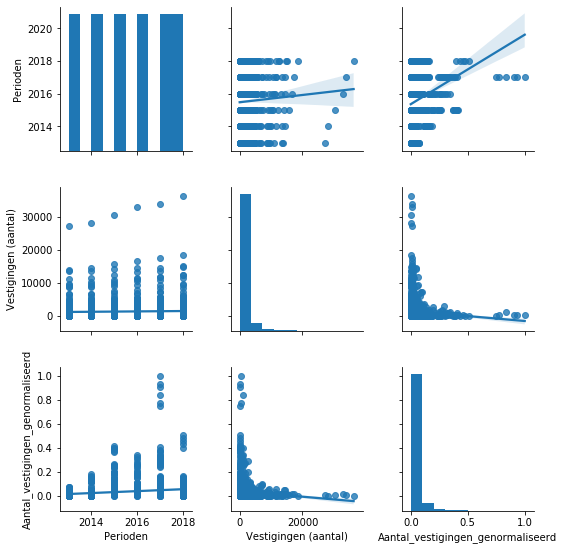

In [216]:
# In de pairplot (zie data understanding) is de voorspelde lineaire regressie nogmaals te zien in de dataset werkgelegenheid_df_lr.
sb.pairplot(werkgelegenheid_df_lr, kind="reg")

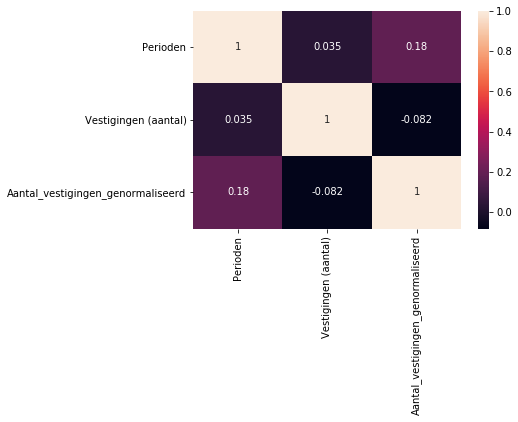

In [217]:
# In de heatmap (zie data understanding) is de voorspelde correlatie tussen de data nogmaals te zien in de dataset werkgelegenheid_df_lr.
sb.heatmap(werkgelegenheid_df_lr.corr(), annot=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001E5DDEA3190>,
      dtype=object)

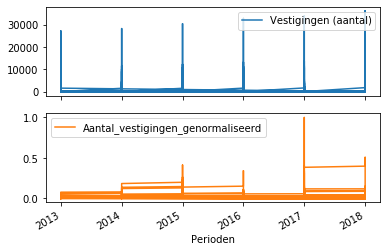

In [218]:
werkgelegenheid_df_lr.plot(subplots=True, x='Perioden')

Op basis van deze bevindingen, wordt er een hypothese opgesteld dat het lineaire regressiemodel niet een bestrouwbare voorspelling kan geven, omdat de hoogste/laagste correlate te dicht bij nul ligt (0.18 en -0.082). 

### Tijdreeksanalyse

In [219]:
# Dataset voor tijdreeksanalyse
werkgelegenheid_df_ta = werkgelegenheid_df
print(werkgelegenheid_df_ta.columns)
print(werkgelegenheid_df_ta.info())

Index(['Provincie', 'Regio's', 'Perioden', 'Bedrijfstak_code', 'Bedrijfstak',
       'Vestigingen (aantal)', 'Aantal_vestigingen_genormaliseerd',
       'Vestigingen Klasse'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1938 entries, 0 to 1937
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Provincie                          1938 non-null   object 
 1   Regio's                            1938 non-null   object 
 2   Perioden                           1938 non-null   int64  
 3   Bedrijfstak_code                   1938 non-null   object 
 4   Bedrijfstak                        1938 non-null   object 
 5   Vestigingen (aantal)               1938 non-null   int64  
 6   Aantal_vestigingen_genormaliseerd  1938 non-null   float64
 7   Vestigingen Klasse                 1938 non-null   object 
dtypes: float64(1), int64(2), object(5)
memory usage: 12

In [220]:
# Dataset voor tijdreeksanalyse
werkgelegenheid_df_ta = werkgelegenheid_df[['Perioden', 'Vestigingen (aantal)']]
werkgelegenheid_df_ta

,Perioden,Vestigingen (aantal)
0,2013,65
1,2013,5
2,2013,160
3,2013,0
4,2013,10
...,...,...
1933,2018,14655
1934,2018,2910
1935,2018,5440
1936,2018,3330


In [221]:
werkgelegenheid_df_ta = werkgelegenheid_df_ta.set_index("Perioden")

In [222]:
# Controleren of het model stabiel is of niet d.m.v. de P-waarde berekenen
from statsmodels.tsa.stattools import adfuller

result = adfuller(werkgelegenheid_df_ta.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.812655
p-value: 0.056489
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


Dit is een P-score van 0, wat betekend dat de data statistisch significant stabiel (stationair) is en bruikbaar is voor onze tijdreeksanalyse. De hypothese is dan dat de tijdreeksanalyse een betrouwbare voorspelling geeft over het verloop van de data.

## Generate Test design

Voor beide modellen wordt de data gesplitst op een train en test set.

### Lineaire Regressie

In [223]:
# Het maken van een split


# Pakken van een X als waarde perioden
lr_x = werkgelegenheid_df_lr[["Perioden"]]

# Pakken van een Y als waarde Aantal vestigingen en Aantal vestigingen genormaliseerd
lr_y = werkgelegenheid_df_lr[["Vestigingen (aantal)", "Aantal_vestigingen_genormaliseerd"]] 

# create training and testing vars
lr_x_train, lr_x_test, lr_y_train, lr_y_test = train_test_split(lr_x, lr_y, test_size=0.3, random_state=56)
print("x train: ", lr_x_train.shape, "y train: ", lr_y_train.shape)
print("x test: ", lr_x_test.shape, "y test: ", lr_y_test.shape)

x train:  (1356, 1) y train:  (1356, 2)
x test:  (582, 1) y test:  (582, 2)


In [224]:
# Meervoudige regressie toepassen
reg = LinearRegression()
mreg = reg.fit(lr_x_train, lr_y_train)

r = reg.score(lr_x_test, lr_y_test)
a = reg.coef_
b = reg.intercept_

lr_y_predict = reg.predict(lr_x_test)

print("lr_y_test : ", lr_y_test, "lr_y_predict : ", lr_y_predict)

_test :        Vestigingen (aantal)  Aantal_vestigingen_genormaliseerd
574                    370                           0.027831
1313                    20                           0.008818
1341                   570                           0.010333
903                    820                           0.042160
1880                  3625                           0.006751
...                    ...                                ...
92                      95                           0.142050
852                    745                           0.062414
670                    300                           0.082392
143                    150                           0.060623
1443                  1580                           0.004547

[582 rows x 2 columns] lr_y_predict :  [[1.26365389e+03 3.79909126e-02]
 [1.44334786e+03 5.32792010e-02]
 [9.94112931e+02 1.50584799e-02]
 [1.44334786e+03 5.32792010e-02]
 [1.17380690e+03 3.03467684e-02]
 [1.26365389e+03 3.79909126e-02]
 [9.94112

In [225]:
print("r_score : ", r)
print("a : ", a)
print("b : ", b)

r_score :  -0.005379411358916773
a :  [[8.98469857e+01]
 [7.64414420e-03]]
b :  [-1.79867869e+05 -1.53726038e+01]


In [226]:
# Fouten bekijken van het model
print(mean_absolute_error(lr_y_test, lr_y_predict))
print(mean_squared_error(lr_y_test, lr_y_predict))
print(np.sqrt(mean_squared_error(lr_y_test, lr_y_predict)))
print(r2_score(lr_y_test, lr_y_predict))
# lm.score(x_test, y_test)

705.1695677739285
4748847.9643048365
2179.1851606288155
0.014274152819645891


De waarden die hier worden weergegeven, onderbouwen de stelling in de hypothese. De formule van lineaire regressie 

### Tijdreeksanalyse

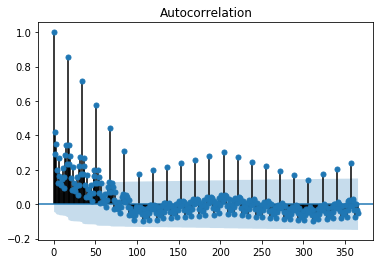

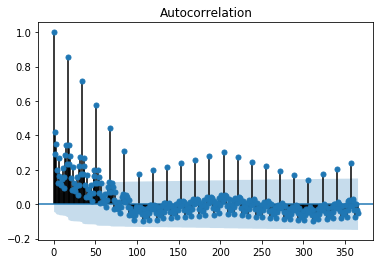

In [240]:
plot_acf(werkgelegenheid_df_ta, lags=365)

Uit deze grafiek blijkt dat de waardes niet goed binnen de blauwe zone liggen van de acf grafiek liggen. Dit betekend dat er voor de MA waarden een andere waarde dan 0 ingesteld moet worden.

We gaan proberen om met een MA waarde 1 te werken. Eerst moet ook nog een 

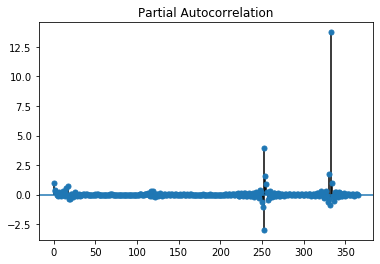

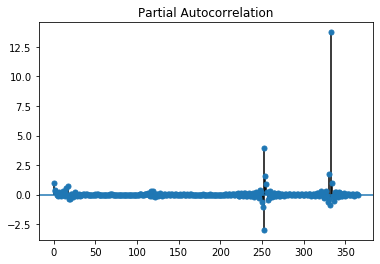

In [229]:
plot_pacf(werkgelegenheid_df_ta, lags=365)

Veruit de meeste waarden liggen rondom nul in de pacf grafiek. We gaan er daarom vanuit dat een AR waarde van 0 voor nu moet voldoen. We gaan nu met de gevonden AR en AM waarden de ARIMA functie uitvoeren. We nemen de standaard I waarde van 1.

C:\githubdocs\DS_Bram\FlaskReact\.env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\githubdocs\DS_Bram\FlaskReact\.env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
                               ARIMA Model Results                                
Dep. Variable:     D.Vestigingen (aantal)   No. Observations:                 1937
Model:                     ARIMA(0, 1, 1)   Log Likelihood              -17825.464
Method:                           css-mle   S.D. of innovations           2399.932
Date:                    Wed, 20 May 2020   AIC                          35656.928
Time:                            10:59:50   BIC                          35673.634
Sa

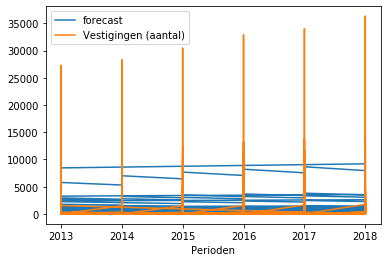

In [238]:
# ARIMA model.
werkgelegenheid_df_ta_model = ARIMA(werkgelegenheid_df_ta, order=(0, 1, 1)).fit()
print(werkgelegenheid_df_ta_model.summary())
fig = werkgelegenheid_df_ta_model.plot_predict(dynamic=False)